# Aufgabe 2.8 - Instationäre Wärmeleitung

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from matplotlib import animation
np.set_printoptions(linewidth=150)
%matplotlib widget

In [2]:
class rb():
    position = 10
    def __init__(self, position):
        self.position = position
    def apply(self, systemmatrix, rhs, delta_x):
        pass
class neumann(rb):
    waermestrom = 5
    def __init__(self, position, waermestrom):
        super(neumann,self).__init__(position)
        self.waermestrom = waermestrom
    def apply(self, systemmatrix, rhs, delta_x):
        if (self.position == 0):
            # Vorwärtsdifferenz
            systemmatrix[self.position, 0:2] = (1, -1)
        elif (self.position < len(rhs)):
            # Rückwärtsdifferenz
            systemmatrix[self.position, self.position-1:self.position+1] = (-1, 1)
        else:
            raise ValueError("Out of bounds")
        rhs[self.position] = rhs[self.position] + self.waermestrom * delta_x
class dirichlet(rb):
    temperatur = 5
    def __init__(self, position, temperatur):
        super(dirichlet,self).__init__(position)
        self.temperatur = temperatur
    def apply(self, systemmatrix, rhs, delta_x):
        if (self.position > len(rhs)):
            raise ValueError("Out of bounds")
        systemmatrix[self.position, self.position] = 1
        rhs[self.position] = rhs[self.position] + self.temperatur
class waermequelle(rb):
    staerke = 5
    kappa = 10
    def __init__(self, position, staerke):
        super(waermequelle,self).__init__(position)
        self.staerke = staerke
    def apply(self, systemmatrix, rhs, delta_x):
        rhs[self.position] = rhs[self.position] + self.staerke * delta_x**2 / self.kappa

In [3]:
def assemble(knoten, l, kappa, Pe, rben, alpha):
    delta_x = l / (knoten-1)
    U = Pe * kappa / l
    systemmatrix = np.zeros((knoten, knoten))
    rhs = np.zeros((knoten))
    for i in range(1, knoten-1):
        systemmatrix[i, i-1:i+2] = kappa / delta_x**2 * np.array((-1, 2, -1)) * alpha
        systemmatrix[i, i-1:i+2] = systemmatrix[i, i-1:i+2] + 0.5 * U / delta_x * np.array((-1, 0, 1)) * alpha
    for rb in rben:
        rb.apply(systemmatrix, rhs, delta_x)        
    return systemmatrix, rhs
def solve(knoten, l, kappa, Pe, rben, zentraldifferenz):
    systemmatrix, rhs = assemble(knoten, l, kappa, Pe, rben, zentraldifferenz)
    solution = np.linalg.solve(systemmatrix, rhs)
    return np.linspace(0, l, knoten), solution, systemmatrix, rhs

### Aufgabe 2.8.1 / 2.8.2

Anfangsbedingung für Temperatur: Temperatur ist überall $T(L)$ außer am ersten Knoten, dort $T(0)$

In [4]:
knoten = 200
t_vorne = 50
t_hinten = 200
rb_vorne = dirichlet(0, t_vorne)
rb_hinten = dirichlet(knoten-1, t_hinten)
l = 10
Pe = 10
kappa = 10
U = Pe * kappa / l
delta_x = l / (knoten-1)
delta_t = 0.01
endtime = 2
timesteps = int(endtime / delta_t)
clf = (U + kappa / delta_x)/(delta_x / delta_t)
results = {}

for alpha in [0, 0.5, 1]:
    T = np.zeros((timesteps+1, knoten))
    T[0] = np.ones((knoten)) * t_hinten
    T[0][0] = t_vorne
    A = assemble(knoten, l, kappa, Pe, [], alpha)[0] * delta_t + np.eye(knoten)
    B = assemble(knoten, l, kappa, Pe, [], -(1-alpha))[0]
    for i in range(1, timesteps+1):
        rhs = np.matmul(B * delta_t + np.eye(knoten), T[i-1])
        T[i] = np.linalg.solve(A, rhs)
    results[alpha] = T


c:\users\jonat\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in matmul


In [5]:
def plot(time=0):
    plt.figure(figsize=(16, 5))
    for alpha in [0, 0.5, 1]:
        plt.subplot(1, 3, int(alpha *2)+1)
        plt.plot(np.linspace(0, l, knoten), results[alpha][int(time/delta_t)])
        plt.title("alpha = {}".format(alpha))
    plt.show()

In [6]:
interact(plot, time=widgets.FloatSlider(min=0, max=endtime, step=delta_t * 10, value=0))
print("CLF: {}".format(clf))

interactive(children=(FloatSlider(value=0.0, description='time', max=2.0), Output()), _dom_classes=('widget-in…

CLF: 41.590999999999994


### Aufgabe 2.8.3
Validierung mit stationärer Lösung:

In [7]:
Pe = -10
knoten = 51
xan = np.linspace(0, l, knoten)
yan = [t_vorne + (np.exp(xv * Pe / l) - 1)/(np.exp(Pe) - 1) * (t_hinten - t_vorne) for xv in xan]

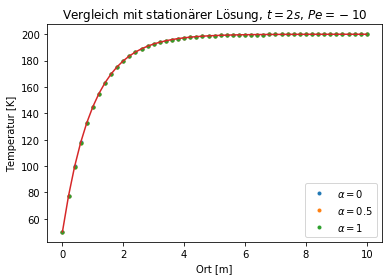

In [8]:
rb_vorne = dirichlet(0, t_vorne)
rb_hinten = dirichlet(knoten-1, t_hinten)
kappa = 10
U = Pe * kappa / l
delta_x = l / (knoten-1)
delta_t = 0.1
endtime = 2
timesteps = int(endtime / delta_t)
clf = (U + kappa / delta_x)/(delta_x / delta_t)
results = {}
for alpha in [0, 0.5, 1]:
    T = np.zeros((timesteps+1, knoten))
    T[0] = yan
    A = assemble(knoten, l, kappa, Pe, [], alpha)[0] * delta_t + np.eye(knoten)
    B = assemble(knoten, l, kappa, Pe, [], -(1-alpha))[0]
    for i in range(1, timesteps+1):
        rhs = np.matmul(B * delta_t + np.eye(knoten), T[i-1])
        T[i] = np.linalg.solve(A, rhs)
    results[alpha] = T
    plt.plot(np.linspace(0, l, knoten), results[alpha][1], ".", label=r"$\alpha=${}".format(alpha))
plt.title("Vergleich mit stationärer Lösung, $t=2s$, $Pe=-10$")
plt.xlabel("Ort [m]")
plt.ylabel("Temperatur [K]")
plt.legend()
plt.plot(xan, results[0.5][20])
plt.show()

Stabilität der Verfahren:

In [9]:
knoten = 50
l = 10
Pe = 10
kappa = 10
U = Pe * kappa / l
delta_x = l / (knoten-1)
results = []
clfzahlen = [0.1, 0.5, 0.603, 0.605, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.5, 2, 5, 9, 10, 11, 15]
for clf in clfzahlen:
    delta_t = clf * delta_x / (U + kappa / delta_x)
    endtime = 2
    timesteps = int(endtime / delta_t)
    for alpha in [0, 0.5, 1]:
        T = np.zeros((timesteps+1, knoten))
        T[0] = np.ones((knoten)) * t_hinten
        T[0][0] = t_vorne
        A = assemble(knoten, l, kappa, Pe, [], alpha)[0] * delta_t + np.eye(knoten)
        B = assemble(knoten, l, kappa, Pe, [], -(1-alpha))[0]
        for i in range(1, timesteps+1):
            rhs = np.matmul(B * delta_t + np.eye(knoten), T[i-1])
            T[i] = np.linalg.solve(A, rhs)
        results = results + [[clf, alpha, delta_t, T, (T[-1][0] - 2*T[-1, 1] + T[-1, 2])/delta_x**2]]
results = np.array(results)

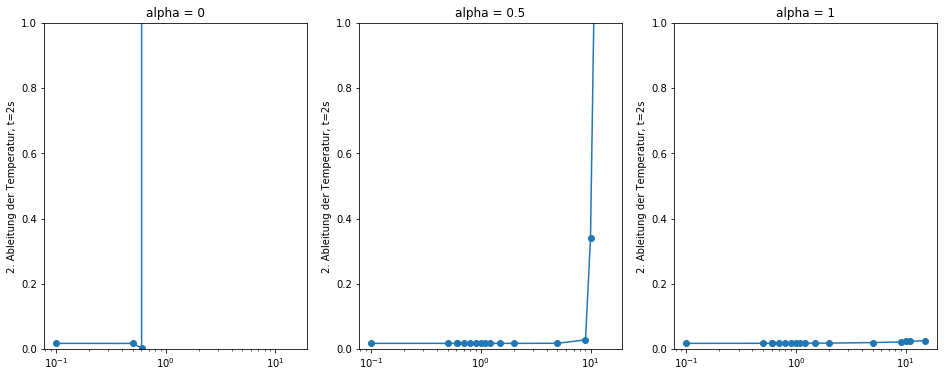

In [10]:
plt.figure(figsize=(16,6))
horizontal = np.array(range(0, 2))
counter = 0
index = 0
bar_width = 0.1
for alpha in [0, 0.5, 1]:
    index = index + 1
    aloesungen = results[np.where(results[:,1]==alpha)]
    ax = plt.subplot(1, 3, index)
    plt.ylabel("2. Ableitung der Temperatur, t=2s")
    ax.set_ylim([0,1])
    ax.set_xscale('log')
    plt.title("alpha = {}".format(alpha))
    knotencounter = 0
    clfloesungen = aloesungen[:,4]
    plt.plot(clfzahlen, abs(clfloesungen), "o-")
    

Ergebnis: 
* Euler explizit bleibt stabil bis etwa $CLF=0.603$
* Crank-Nicholson bleibt stabil bis etwa $CLF=11$